<a href="https://colab.research.google.com/github/Gadgeteering/Lego-Machine-Learning-Dataset/blob/master/Lego_Sorter_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

import subprocess
from functools import partial
from multiprocessing.pool import Pool
import os
import sys
import pandas as pd
import wget
from pathlib import Path
import zipfile

ldraw_fname = "complete.zip"
dataset_files_base = 'ldraw/parts/'
dataset_path = '/content/drive/My Drive/DATA/LEGO-brick-images/parts.csv'
config_fname = 'augmentation.json'
output_path = '/content/drive/My Drive/DATA/LEGO-brick-images/'
url = "http://www.ldraw.org/library/updates/complete.zip"

if (Path(dataset_files_base).is_dir() ==False):
    wget.download(url,ldraw_fname )
    with zipfile.ZipFile(ldraw_fname,"r") as zip_ref:
        zip_ref.extractall("")
number_of_images = 2000

df = pd.read_csv(dataset_path, encoding='utf-8', index_col='part_num')

dataset_files = [os.path.join(dataset_files_base, str(f) + '.dat') for f in df.index]
# dataset_files = dataset_files[:20]

# todo: load background images in memory before rendering process begins, possible in blender?
# alternative: remove already used "background material" in blender
def _render(idx_fname, output_path: str, list_length: int, config_fname: str, number_of_images=1):

    index, fname = idx_fname
    part_id = os.path.splitext(os.path.basename(fname))[0]
    if os.path.exists(os.path.join(output_path, part_id)):
        print('{} ({}/{}): already exists'.format(fname, index + 1, list_length))
        return
    print('{} ({}/{}): render'.format(fname, index + 1, list_length))
    command_path =""
    if sys.platform =='darwin':
        command_path ="/Applications/Blender/blender.app/Contents/MacOS/" # required for OSX
    render_script_path = os.path.join(os.path.dirname(__file__), 'blender', 'render.py')
    command = command_path + 'blender -b -P ' + render_script_path + ' --' \
              + ' -i ' + fname \
              + ' -c ' + config_fname \
              + ' -s ' + os.path.join(output_path, part_id) \
              + ' -n ' + str(number_of_images)
    try:
        p = subprocess.Popen(command, shell=True, stdout=subprocess.DEVNULL)
    # except Exception as e:
    #     print(e)
    except subprocess.TimeoutExpired as e:
        print(e)
    finally:
        p.wait(timeout=30)


with Pool(1) as p:
    _partial = partial(_render,
                       output_path=output_path,
                       list_length=len(dataset_files),
                       config_fname=config_fname,
                       number_of_images=number_of_images)
    p.map(_partial, enumerate(dataset_files), chunksize=1)


#_render((0, os.path.join(dataset_files_base, '2698c01.dat')), output_path, 1, config_fname, number_of_images=5)


# for idx, dataset_file in enumerate(dataset_files):
#     _render((idx, dataset_file), output_path, len(dataset_files), config_fname, number_of_images)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ldraw/parts/004285.dat (1/34238): render
ldraw/parts/004590.dat (2/34238): render
ldraw/parts/004591.dat (3/34238): render
ldraw/parts/004602.dat (4/34238): render
ldraw/parts/004632.dat (5/34238): render
ldraw/parts/0687b1.dat (6/34238): render
ldraw/parts/0901.dat (7/34238): render
ldraw/parts/0902.dat (8/34238): render
ldraw/parts/0903.dat (9/34238): render
ldraw/parts/0904.dat (10/34238): render
ldraw/parts/1.dat (11/34238): render
ldraw/parts/10.dat (12/34238): render
ldraw/parts/10000.dat (13/34238): render
ldraw/parts/10010492.dat (14/34238): render
ldraw/parts/10016414.dat (15/34238): render
ldraw/parts/10039.dat (16/34238): render
ldraw/parts/10048.dat (17/34238): render
ldraw/parts/10049.dat (18/34238): render
ldraw/parts/10049pr0001.dat (19/34238): render
ldraw/parts/10050.dat (20/34238): render
ldraw/parts/10051.dat (21/34238): render
ldraw/parts/

NameError: ignored

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

import random
import glob
import os
import pathlib
import time
import matplotlib.pyplot as plt
from datetime import datetime
from packaging import version
import IPython.display as display
import pandas

from google.colab import drive
drive.mount('/content/drive')


# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 


##train_path = ""/Users/petesmac/Documents/Machine Learning/DATA/LEGO brick images/train'
##valid_path = '/Users/petesmac/Documents/Machine Learning/DATA/LEGO brick images/valid'
dataset_path = '/Users/petesmac/Documents/Machine Learning//DATA/LEGO-brick-images/dataset.csv'
train_path = '/Users/petesmac/Documents/Machine Learning/DATA/LEGO-brick-images/train'
valid_path = '/Users/petesmac/Documents/Machine Learning/DATA/LEGO-brick-images/valid'
df = pd.read_csv(dataset_path, skipinitialspace=True, skip_blank_lines=True,encoding='utf-8', index_col='id')

label_names =  [( str(f)) for f in df.index]
#label_names = ['2357','3003','3004']
print (label_names)
path= "/content/drive/My Drive/DATA/LEGO-brick-images"
data_root = pathlib.Path(path)

class_size=len(label_names)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_directory(path, target_size=(224,224), classes=label_names, batch_size=32)
valid_batches = valid_datagen.flow_from_directory(path, target_size=(224,224), classes=label_names, batch_size=32)
test_batches = test_datagen.flow_from_directory(path, target_size=(224,224), classes=label_names, batch_size=32)
 
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_tensor=Input(shape=(224,224,3)))
#vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))


# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(image_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_size, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                             histogram_freq=1,
                             write_graph=True,
                             write_images=True,
                             write_grads=True,
                             batch_size=32)

history = model.fit_generator(
      train_batches,
      steps_per_epoch=train_batches.samples/train_batches.batch_size ,
      epochs=5,
      validation_data=valid_batches,
      validation_steps=valid_batches.samples/valid_batches.batch_size,
      verbose=1,
      callbacks=[tensorboard_callback])
model.evaluate(test_batches)
%tensorboard --logdir logs

saved_model_path = "/content/drive/My Drive/tmp/saved_models/"+str(int(time.time()))
keras.experimental.export_saved_model(model, saved_model_path)

     |████████████████████████████████| 348.9MB 51kB/s 
     |████████████████████████████████| 3.1MB 50.8MB/s 
     |████████████████████████████████| 501kB 53.8MB/s 


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

2.0.0-beta1
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


NameError: ignored

# New Section

This notebook provides recipes for loading and saving data from external sources.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['11214 Bush 3M friction with Cross axle', '18651 Cross Axle 2M with Snap friction', '2357 Brick corner 1x2x2', '3003 Brick 2x2', '3004 Brick 1x2', '3005 Brick 1x1', '3022 Plate 2x2', '3023 Plate 1x2', '3024 Plate 1x1', '3040 Roof Tile 1x2x45deg', '3069 Flat Tile 1x2', '32123 half Bush', '3673 Peg 2M', '3713 Bush for Cross Axle', '3794 Plate 1X2 with 1 Knob', '6632 Technic Lever 3M']
None
RGB
(224, 224)
(1, 224, 224, 3)
(1, 16)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)          

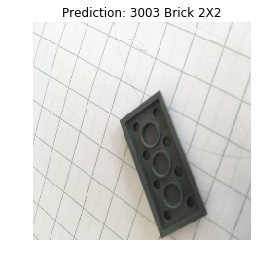

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
from tensorflow import keras

import numpy as np
import PIL.Image as Image
from google.colab import drive
import pathlib
import csv
drive.mount('/content/drive')
from tensorflow.keras import layers
path= "/content/drive/My Drive/DATA/LEGO brick images"
with open(path+"/labels.csv", 'r') as f:
  reader = csv.reader(f,quoting=csv.QUOTE_ALL)
  label_names = list(reader)
label_names=label_names[0]
print (label_names)
saved_model_path = "/content/drive/My Drive/tmp/saved_models/1563634289/"
test_path = '/content/drive/My Drive/DATA/LEGO brick images/test6.JPG'
IMAGE_SHAPE = (224, 224)
img =Image.open(test_path).resize(IMAGE_SHAPE)
print(img.format)
print(img.mode)
print(img.size)
img=img.convert('RGB')


#print(img.shape)
img = np.array(img)/255.0
imgr = tf.reshape(img, [1,224, 224, 3])
print(imgr.shape)
classifier = tf.keras.experimental.load_from_saved_model(saved_model_path)

result = classifier.predict(imgr)
print(result.shape)
classifier.summary()
#print(classifier.predict(img).shape)
print(np.argmax(result[0]))
predicted_class = np.argmax(result[0], axis=-1)
print(predicted_class)
img = tf.reshape(img, [224, 224, 3])
plt.imshow(img)
plt.axis('off')
predicted_class_name = label_names[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())


In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1
%load_ext tensorboard

In [0]:
!ls
!ls 'drive/My Drive/'tmp/saved_models/
!saved_model_cli show --dir 'drive/My Drive/tmp/saved_models/1563479506' --tag_set serve

drive  sample_data
1563018592  1563048769	1563133774  1563399890	1563479506
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [0]:
%tensorboard --logdir 'logs'